In [55]:
# For plotting hw8 results
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from hw8_jf import multivariate_metropolis_hastings, hw8_pdf

In [59]:
## Run MCMC simulations for different sample sizes (~30 seconds runtime)
# parameters
n_mcmc_samples = [1000, 10_000, 100_000]
burnins = [n // 10 for n in n_mcmc_samples]
alpha = 0.5    
np.random.seed(0)                                      
                                                                                
# Run MCMC for different size problems                                                                   
x0 = np.array([0., 0.])  
x_mcmcs = []
y_mcmcs = []      
for (n_samples, burnin) in zip(n_mcmc_samples, burnins):
    
    samples, acceptance_probabilities = multivariate_metropolis_hastings(          
        x0,                                                                        
        n_samples + burnin,                                                        
        target_pdf=hw8_pdf,                                                        
        alpha=alpha)

    x_mcmc = samples[burnin:, 0]                                                           
    y_mcmc = samples[burnin:, 1]

    x_mcmcs.append(x_mcmc)
    y_mcmcs.append(y_mcmc)

Multivariate Metropolis-Hastings: 100%|██████████| 110000/110000 [00:29<00:00, 3787.82it/s]


Text(0.5, 1.0, 'Metropolis-Hastings Hexbins with Target PDF Contour Lines\nMean Acceptance Probability: 0.32')

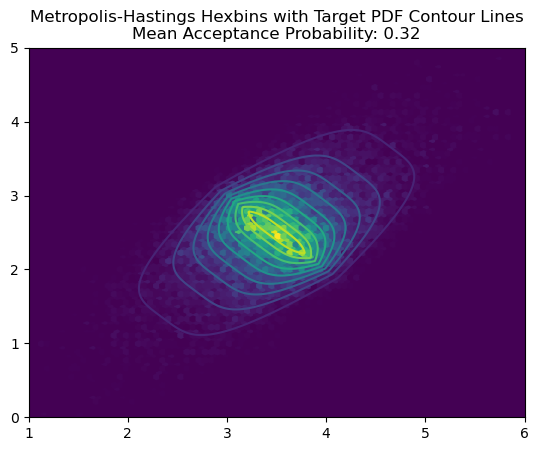

In [60]:
## MCMC path as heat map with target pdf superimposed
n_points = 500                                                                 
x = np.linspace(0, 6, n_points)                                                   
y = np.linspace(0, 5, n_points)                                                   
X, Y = np.meshgrid(x, y)                                                          
Z = hw8_pdf([X, Y])  # target pdf

plt.hexbin(x_mcmcs[-1], y_mcmcs[-1], label = "MCMC Simulation")
plt.contour(X, Y, Z, levels=10)  
plt.xlim(1, 6)
plt.ylim(0, 5)
plt.title(
    "Metropolis-Hastings Hexbins with Target PDF Contour Lines"
    f"\nMean Acceptance Probability: {round(np.mean(acceptance_probabilities), 2)}")

Text(0.5, 0.98, 'Rolling Mean of Metropolis-Hastings Samples of Different Sizes')

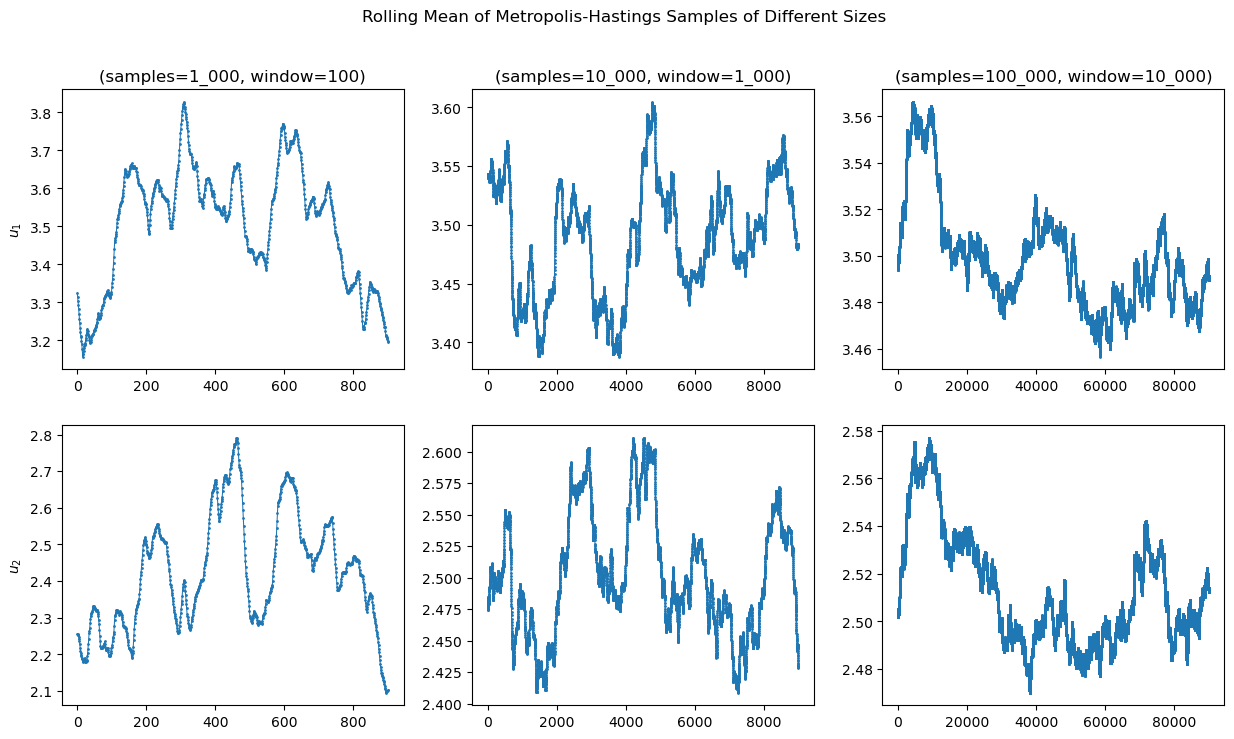

In [67]:
## The below plots shows how as the MCMC sample size increases,
## the magnitude of oscillations in the sampling points decreases
## (i.e., your sampling begins to stabilize around the target distribution)

# Compute rolling mean (aka, moving average, running mean) over some
# array x for a window size w
moving_average = lambda x, w: np.convolve(x, np.ones(w), "valid")/w

fig, axs = plt.subplots(nrows=2, ncols=len(burnins), figsize=(15, 8))

# iterate over MCMC samples, compute rolling means, and plot
for ix, (x_mcmc, y_mcmc) in enumerate(zip(x_mcmcs, y_mcmcs)):
    # compute rolling mean and use burnin size as window size
    x_mcmc_rolling_mean = moving_average(x_mcmc, burnins[ix])
    y_mcmc_rolling_mean = moving_average(y_mcmc, burnins[ix])
    t_points = range(len(x_mcmc_rolling_mean))

    axs[0, ix].plot(
        t_points, x_mcmc_rolling_mean, marker="o", markersize=1, linewidth=0.75)
    axs[0, ix].set_title(f"(samples={n_mcmc_samples[ix]:_}, window={burnins[ix]:_})")

    axs[1, ix].plot(
        t_points, y_mcmc_rolling_mean, marker="o", markersize=1, linewidth=0.75)

axs[0, 0].set_ylabel(r"$u_1$")
axs[1, 0].set_ylabel(r"$u_2$")
fig.suptitle(
    "Rolling Mean of Metropolis-Hastings Samples of Different Sizes") 